This notebook presents the application of Differential Evolution to the problem of optimally controlling the 
stretcher parameters of the L1 pump Laser. In particular, in this notebook, various loss functions are experimented in the sake of identifying the one yielding the optimal pulse shape. 

Author: Francesco Capuano, 2022 S17 summer intern @ ELI-beamlines, Prague

# Setting
The goal of this project is to maximise second-harmonic efficiency. 

However, since this metric is also very much related to the shortest possible pulse shape, we developed a strategy to optimise a predefinite set of control parameters so as to minimise the difference between the obtained pulse shape (in the temporal domain) and a target one (which is, by default, the shortest one).

This process is very much intensive for what concerns the number of function evaluation we needed to use and, because of that, we resorted to use a custom-built fast-running forward model used to approximate/predict the temporal  profile of the pulse given a set of parameters. 

In particular, if one indicates with $\psi = \big( d_1, d_2, d_3 \big)$ the control configuration of the stretcher and with $E(\nu)$ the electric field in the frequency domain of the signal considered, then the fast running model we developed approximates $ \tilde{\tau}(\psi; E(\nu)) $, hopefully similar enough to the actual ${\tau}(\psi; E(\nu))$ that can be collected only through practical observation on the real hardware. 

If one has a target temporal profile $\tau^*$ of the pulse then it the problem can be framed as: 

$$\min_{\psi} L\big[ \tilde{\tau}(\psi; E(\nu)), \tau^*\big]$$

With $L$ being some sort of loss function. 

The solution of this problem can be obtained, in principle, using Differential Evolution. In this notebook, this is the approach that is tried out. 

Clearly enough, the solution to this problem  depends on the Loss function being used. 

In [1]:
# these imports are necessary to import modules from directories one level back in the folder structure
import sys
sys.path.append("../..")

from algorithms.L1_DifferentialEvolution import extract_data, model, diff_evolution
from utils import physics
from utils.losses import Losses
from scipy.optimize import Bounds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
frequency, intensity = extract_data() # extracting the desired information

# compressor parameters - obtained as minus the stretcher one - TO BE FIXED WITH REAL ONES ONCE THEY ARE AVAILABLE
COMPRESSOR = -1 * np.array((267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50)) # in s^2, s^3 and s^4 (SI units)
# non linearity parameter
B = 2
# cutoff frequencies, in THz, used to remove noise - derived from visual inspection
CUTOFF = (289.95, 291.91)
# model instantiation
l1_pump = model(frequency, intensity, COMPRESSOR, B, CUTOFF, num_points=int(5e3))

To make the design of new loss functions practical the `Losses` object has been created. In particular, this object takes as input an instance of the `LaserModel` class and uses it to carry out necessary computations. 

In [3]:
losses = Losses(l1_pump)

The bounds of the optimisation process are defined considering that: 

1. The value of GDD is tunable only in a region which is a little bit more than $\pm$ 10% of its nominal value.

2. TOD is tunable practically without limits in the case in which the bounds are defined using percentages of the nominal values. 

3. FOD is tunable practically without limits in the case in which the bounds are defined using percentages of the nomnal values. 

In this specific case however the bounds are defined considering the nomial value plus-minus half of the full tunable range as by the technical specification, which in this case are: 

1) **GDD**: $267.422 \pm 32.202 \ (ps^2) \equiv [235.22, 299.624] \ (ps^2) \equiv [2.3522 \cdot 10^{-22}, 2.99624 \cdot 10^{-22}] \ (s^2)$ 

2) **TOD**: $-2.384 \pm 97.9795 \ (ps^3) \equiv [-100.3635, 95.5955] \ (ps^3) \equiv [-1.003635 \cdot 10^{-34}, 9.55955 \cdot 10^{-35}] \ (s^3)$

3) **FOD**: $ 0.0954893 \pm 0.04774465 \ (ps^4) \equiv [0.04774465, 0.14323395] \ (ps^4) \equiv [4.774465 \cdot 10^{-49}, 1.4323395 \cdot 10^{-49} ] \ (s^{4})$

In [4]:
bounds_DE = Bounds(
            # GDD         # TOD          # FOD
    lb = (2.3522e-22, -1.003635e-34, 4.774465e-50),
    ub = (2.99624e-22, 9.55955e-35, 1.4323395e-49)
)

bounds_matrix = np.vstack((bounds_DE.lb, bounds_DE.ub)).T
disp_bounds = np.sort(l1_pump.translate_control(bounds_matrix, verse = "to_disp"))

Surely enough various loss functions can be defined. In particular: 

1. One which **weights every error by the value of the intensity**, so as to reduce the weight of the marginal errors with respect to those large ones present in the central area of the pulse, i.e. $$ \frac{\Vert t (t - t_{TL})\Vert^2}{t^T \mathbb 1}$$

2. One which computes the **MSE only for non-zero values**, and which therefore discards those long tails of the pulse.

3. A mixture of (2) and a measure of **the mismatch in terms of area underlied by controlled and target pulse** (weighted in favour of difference of area).

4. One which mixes (2) with a minimisation of the total sum of peak widhts (weighted in favour of difference of total width sum).

5. One which minimises the pulse shape but prefers to **minimize the difference in FWHM** between the target pulse and the controlled one. 

6. One which is based on **L1-Manhattan norm**.

In [5]:
print("LOSS_1")
# loss-1
best1 = diff_evolution(
    objective_function = losses.loss1,
    bounds = disp_bounds,
    verbose = 1, 
    maxit = 500, 
    print_every = 50
)

LOSS_1
Iteration 0 - Objective Function value: 0.12070731145299221
Iteration 50 - Objective Function value: 0.07504570742679371
Iteration 100 - Objective Function value: 0.06196630873733907
Iteration 150 - Objective Function value: 0.007012316580334863
Iteration 200 - Objective Function value: 0.0020560300493714045
Iteration 250 - Objective Function value: 0.0020559816866822255
Iteration 300 - Objective Function value: 0.002055981686681707
Iteration 350 - Objective Function value: 0.002055981686681675
Iteration 400 - Objective Function value: 0.0020559816866816487
Iteration 450 - Objective Function value: 0.0020559816866816487


In [6]:
print("LOSS_2")
# loss-2
best2 = diff_evolution(
    objective_function = losses.loss2,
    bounds = disp_bounds,
    verbose = 1, 
    maxit = 500, 
    print_every = 50
)

LOSS_2
Iteration 0 - Objective Function value: 0.002895021931488419
Iteration 50 - Objective Function value: 0.001531133870006224
Iteration 100 - Objective Function value: 0.0015305038167570866
Iteration 150 - Objective Function value: 0.0015303719628191048
Iteration 200 - Objective Function value: 0.0015303236214709729
Iteration 250 - Objective Function value: 0.001530281614544438
Iteration 300 - Objective Function value: 0.0015302809738522325
Iteration 350 - Objective Function value: 0.0015302803244781403
Iteration 400 - Objective Function value: 0.0015302803006784242
Iteration 450 - Objective Function value: 0.0015302803002371738


In [7]:
print("LOSS_3")
# loss-3
best3 = diff_evolution(
    objective_function = losses.loss3,
    bounds = disp_bounds,
    verbose = 1, 
    maxit = 500, 
    print_every = 50
)

LOSS_3
Iteration 0 - Objective Function value: 27.333853315123804
Iteration 50 - Objective Function value: 2.076181085643238
Iteration 100 - Objective Function value: 2.025921631261327
Iteration 150 - Objective Function value: 2.0259216299793623
Iteration 200 - Objective Function value: 2.0259216299793437
Iteration 250 - Objective Function value: 2.0259216299793437
Iteration 300 - Objective Function value: 2.025921629979323
Iteration 350 - Objective Function value: 2.025921629979323
Iteration 400 - Objective Function value: 2.025921629979323
Iteration 450 - Objective Function value: 2.025921629979323


In [8]:
print("LOSS_4")
# loss-4
best4 = diff_evolution(
    objective_function = losses.loss4,
    bounds = disp_bounds,
    verbose = 1, 
    maxit = 500, 
    print_every = 50
)

LOSS_4
Iteration 0 - Objective Function value: 1877.7816657886012
Iteration 50 - Objective Function value: 0.12104661563733315
Iteration 100 - Objective Function value: 0.10123895987332723
Iteration 150 - Objective Function value: 0.10123640385063072
Iteration 200 - Objective Function value: 0.10123640093300022
Iteration 250 - Objective Function value: 0.1012364009326424
Iteration 300 - Objective Function value: 0.10123640093262863
Iteration 350 - Objective Function value: 0.10123640093262863
Iteration 400 - Objective Function value: 0.10123640093262447
Iteration 450 - Objective Function value: 0.10123640093262005


In [9]:
print("LOSS_5")
# loss-5
best5 = diff_evolution(
    objective_function = losses.loss5,
    bounds = disp_bounds,
    verbose = 1, 
    maxit = 500, 
    print_every = 50
)

LOSS_5
Iteration 0 - Objective Function value: 0.00015431180940457382
Iteration 50 - Objective Function value: 0.00015324308812243135
Iteration 100 - Objective Function value: 0.00015312729722364636
Iteration 150 - Objective Function value: 0.0001530280480690941
Iteration 200 - Objective Function value: 0.00015302804161425126
Iteration 250 - Objective Function value: 0.0001530280396773668
Iteration 300 - Objective Function value: 0.00015302803927502134
Iteration 350 - Objective Function value: 0.00015302803925551335
Iteration 400 - Objective Function value: 0.0001530280392542231
Iteration 450 - Objective Function value: 0.00015302803925420713


In [10]:
print("LOSS_6")
# loss-6
best6 = diff_evolution(
    objective_function = losses.loss6,
    bounds = disp_bounds,
    verbose = 1, 
    maxit = 500, 
    print_every = 50
)

LOSS_6
Iteration 0 - Objective Function value: 74.07405338567851
Iteration 50 - Objective Function value: 5.1579490691352845
Iteration 100 - Objective Function value: 4.567488088077019
Iteration 150 - Objective Function value: 4.567483378098297
Iteration 200 - Objective Function value: 4.567483377651785
Iteration 250 - Objective Function value: 4.567483377644801
Iteration 300 - Objective Function value: 4.567483377644736
Iteration 350 - Objective Function value: 4.567483377644736
Iteration 400 - Objective Function value: 4.567483377644736
Iteration 450 - Objective Function value: 4.567483377644736


In [11]:
# final comparison
results = [l1_pump.forward_pass(best) for best in [best1, best2, best3, best4, best5, best6]]

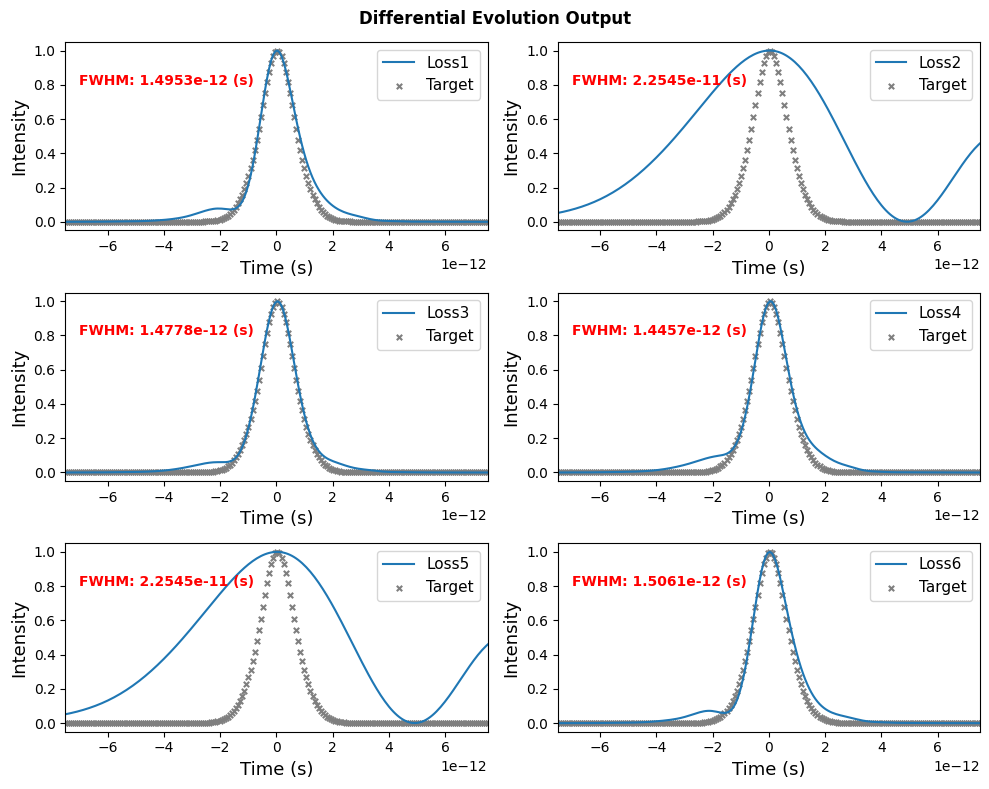

In [13]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10,8))
count = 0
for row_idx in range(3): 
    for col_idx in range(2): 
        current = ax[row_idx, col_idx]
        
        time, profile = results[count]
        current.plot(losses.target_time,
                     np.roll(profile, - np.argmax(profile) + np.argmax(losses.target_profile)),
                     label = f"Loss{count+1}", lw = 1.5)
        
        current.scatter(losses.target_time, losses.target_profile, c = "tab:grey", marker = "x", s = 15, label = "Target")
        current.annotate(text = "FWHM: {:.4e} (s)".format(physics.FWHM(time, profile)),
                 xy=(-7e-12, 0.8),
                 fontweight = "bold",
                 color = "red")
        
        count += 1
        current.legend(fontsize = 11)
        current.set_xlabel("Time (s)", fontsize = 13); current.set_ylabel("Intensity", fontsize = 13)
        current.set_xlim(left = -0.75e-11, right = +0.75e-11) 

fig.suptitle("Differential Evolution Output", fontweight = "bold", fontsize = 12)
fig.tight_layout()

This figure shows that Loss3 it the one yielding the best resutl in terms of convergence. 
However, the pedestals of the resulting pulse is large enough to justify the need of carrying out a phase of hyperparameter exploration. This process is carried out in `hyp_opt.ipynb`. 